In [27]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_wine
from optuna.samplers import TPESampler
import xgboost as xgb
import pickle
import optuna
import pandas as pd
import re

import numpy as np
from pymatgen.core.ion import Ion
import json
import os
import tensorflow as tf
import copy
import joblib
import argparse
import sys
from functools import reduce
import statistics

import seaborn as sns

# Usefull functions

In [2]:
def smart_cross_val(df, model, params):
    elems_list = []
    df['elems'] = df['Material'].apply(lambda x: Ion.from_formula(x).elements)
    df['elems'] = df['elems'].apply(lambda x: str(x[0]).replace('Element ', ''))
    
    for i in range(df['elems'].shape[0]):
        elems_list = elems_list + [df['elems'][i]]
        
    elems_list = list(set(elems_list))  
    mse = []
    r2 = []
    for elem in elems_list:
        df['is_elem'] = df['elems'].str.contains(elem)
        train = df[df['is_elem']==False]
        test = df[df['is_elem']==True]
        
        X_train, y_train = train.drop(columns=['Material', 'EFA', 'elems', 'is_elem']), train['EFA']
        X_test, y_test = test.drop(columns=['Material', "EFA", 'elems', 'is_elem']), test['EFA']
        
        model_cross = model(**params,
                           silent=True)
        model_cross.fit(X_train, y_train)
        
        predictions = model_cross.predict(X_test)
        mse.append(mean_absolute_error(y_test, predictions))
        r2.append(r2_score(y_test, predictions))
    return mse, r2

In [3]:
def objective_cb(trial):
    
    model = CatBoostRegressor(
        iterations=trial.suggest_int("iterations", 50, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return mean_absolute_error(y_test, y_pred)

In [4]:
def objective_xgb(trial):
    
    """Define the objective function """

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBRegressor(**params)
    optuna_model.fit(X_train, y_train)

    y_pred = optuna_model.predict(X_test)

    return mean_absolute_error(y_test, y_pred)

In [5]:
with open('../HECC_phase_prediction-main/properties_of_precursors.json', 'r') as json_file:

    pre_prop = json.load(json_file)
    prop_list = ['mixing_entropy',
                  'mean_volume',
                  'diff_volume',
                  'mean_mass',
                  'diff_mass',
                  'mean_density',
                  'diff_density',
                  'mean_VEC',
                  'diff_VEC',
                  'diff_electronegativity']

def get_feat(comp):
    ele_name_list   = [x.name for x in comp.elements]
    atomic_con_list = [comp.get_atomic_fraction(x) for x in ele_name_list]
    pre_list        = [x + 'C' for x in ele_name_list]
    num_of_pre      = len(ele_name_list)
    feat_dict = {}

    # mixing entropy
    feat_dict['mixing_entropy'] = 0.
    for i in range(num_of_pre):
        feat_dict['mixing_entropy'] += -8.3145 * atomic_con_list[i] * np.log(atomic_con_list[i])

    for prop in ['volume', 'mass', 'density', 'VEC', 'electronegativity']:
        feat_dict['mean_' + prop], feat_dict['diff' + prop] =  0.0, 0.0
        for i in range(num_of_pre):
            feat_dict['mean_' + prop] += pre_prop[pre_list[i]][prop + '_per_formula'] * atomic_con_list[i]
        prop_diff_std_sqr = 0.0
        for i in range(num_of_pre):
            prop_diff_std_sqr += atomic_con_list[i] * (1 - pre_prop[pre_list[i]][prop + '_per_formula'] / feat_dict['mean_' + prop]) ** 2
        feat_dict['diff_' + prop] = prop_diff_std_sqr ** 0.5
    feat = [feat_dict[x] for x in prop_list]
    return feat

def scale_feat(feat):
    feat = copy.deepcopy(feat)
    number_of_features = np.shape(feat)[1]
    with open('../HECC_phase_prediction-main/OtherFiles/models/variables.txt', 'r') as f:
        x_min, x_max = [], []
        comment = f.readline()
        for i in range(number_of_features):
            line = f.readline()
            x_min.append(float(line))
        blank = f.readline()
        comment = f.readline()
        for i in range(number_of_features):
            line = f.readline()
            x_max.append(float(line))
    for i in range(np.shape(feat)[1]):
        for j in range(np.shape(feat)[0]):
            feat[j][i] = (feat[j][i] - x_min[i]) / (x_max[i] - x_min[i])
    return feat

def load_ann():
    number_of_models = len(os.listdir('../HECC_phase_prediction-main/OtherFiles/models/ANN'))
    ann_models = []
    for i in range(number_of_models):
        model_name = os.path.join('../HECC_phase_prediction-main/OtherFiles/models/ANN', 'model_'+str(i + 1)+'_dense_layer.model')
        ann_models.append(tf.keras.models.load_model(model_name))
    return ann_models

def load_svm():
    number_of_models = len(os.listdir('../HECC_phase_prediction-main/OtherFiles/models/SVM'))
    svm_models = []
    for i in range(number_of_models):
        model_name = os.path.join('../HECC_phase_prediction-main/OtherFiles/models/SVM', 'model_'+str(i)+'.svm')
        svm_models.append(joblib.load(model_name))
    return svm_models

def pred_from_ann(feat): # type of feat: np.array or a list of list
    ann_pred_list = []
    for ann in load_ann():
        ann_pred_list.append(ann(feat))
    ann_pred_list = np.array(ann_pred_list)
    ann_pred_list = np.mean(ann_pred_list, axis=0)
    return ann_pred_list

def pred_from_svm(feat): # type of feat: np.array
    svm_pred_list = []
    for svm in load_svm():
        svm_pred_list.append(svm.predict(feat))
    svm_pred_list = np.array(svm_pred_list)
    svm_pred_list = np.mean(svm_pred_list, axis=0)
    return svm_pred_list

def calc_features_by_formula(formula_list):
    comp_list = [Ion.from_formula(x) for x in formula_list]
    feat_list = [get_feat(comp) for comp in comp_list]
    feat_list = scale_feat(feat_list)
    feat_list = reduce(lambda a, b: a + b, feat_list)
    formula_list[0] = '('+formula_list[0]+')'+'C'
    value = [feat_list +formula_list]
    columns = prop_list+['Material']
    tmp_values_df = pd.DataFrame(columns=columns, data=value)
    tmp_values_df['Material']=tmp_values_df['Material'].astype('str')
    return tmp_values_df

In [6]:
# res = calc_features_by_formula([result_df['Material'].unique()[0][1:-2]])
# res

# Load data

In [7]:
dataset_1 = pd.read_csv('./additional_data/dataset_from_www.nature.com_articles_s41524-021-00678-3.csv')[['Material', 'EFA']] # from https://www.nature.com/articles/s41524-021-00678-3#data-availability
dataset_2 = pd.read_excel('./data/Orig_56_HECs_EFA_wCalphad.xlsx')[['Name', 'EFA']] # original dataset

In [8]:
# обработка dataset_2 к нужному виду

dataset_2['Material'] = dataset_2['Name'].apply(lambda x: '('+re.sub(r'[^\w\s]+|[\d]+', r'', x).strip().replace("_", "")[1:]+')'+'C')\
    .astype('str')
dataset_2 = dataset_2.drop(columns='Name')

result_df=pd.concat([dataset_1, dataset_2])
result_df = result_df.drop_duplicates()
result_df['Material'] = result_df['Material'].astype('str')

# Create features

In [9]:
print('Всего различных элементов', result_df['Material'].nunique())

Всего различных элементов 100


In [10]:
all_features_df = pd.DataFrame(columns=['mixing_entropy',
                  'mean_volume',
                  'diff_volume',
                  'mean_mass',
                  'diff_mass',
                  'mean_density',
                  'diff_density',
                  'mean_VEC',
                  'diff_VEC',
                  'diff_electronegativity', 
                  'Material'])
for elem in result_df['Material'].unique():
    formula_list = [elem[1:-2]]
    features_df = calc_features_by_formula(formula_list)
    all_features_df = pd.concat([all_features_df, features_df])
    
result_df = result_df.merge(all_features_df, on=['Material'],how='left').dropna()

# Optuna

In [11]:
X, y = result_df.drop(columns=['Material', 'EFA']), result_df['EFA']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

## cb reg

In [12]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="catboost", direction="minimize", sampler=sampler)
study.optimize(objective_cb, n_trials=1000)

In [13]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 1000
Best trial:
  Value: 26.598700610580234
  Params: 
    iterations: 91
    learning_rate: 0.05658529733560719
    depth: 4
    l2_leaf_reg: 4.992993639355386
    bootstrap_type: Bayesian
    random_strength: 6.939143350857714e-06
    bagging_temperature: 0.0008543118383571181
    od_type: IncToDec
    od_wait: 15


In [14]:
best_params_cb = study.best_params

# xgb reg

In [15]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="xgb", direction="minimize", sampler=sampler)
study.optimize(objective_xgb, n_trials=1000)

C:\Users\koval\AppData\Local\Temp\ipykernel_14160\1640320517.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\koval\AppData\Local\Temp\ipykernel_14160\1640320517.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\koval\AppData\Local\Temp\ipykernel_14160\1640320517.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample',

In [16]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 1000
Best trial:
  Value: 25.276782155036926
  Params: 
    max_depth: 1
    learning_rate: 0.028924750448770856
    n_estimators: 340
    min_child_weight: 3
    gamma: 3.106596884057016e-05
    subsample: 0.9189235147584326
    colsample_bytree: 0.9955191824432122
    reg_alpha: 0.00033585906481623624
    reg_lambda: 7.121834339848721e-05


In [17]:
best_params_xgb = study.best_params

# Smart CrossVal with best params for each model

## cb

In [18]:
result_df['elems'] = result_df['Material'].apply(lambda x: Ion.from_formula(x).elements)

In [19]:
mae_cb_cross_val, r2_cb_cross_val = smart_cross_val(result_df, CatBoostRegressor, best_params_cb)

In [24]:
(mae_cb_cross_val, r2_cb_cross_val)

([47.65271266131786,
  31.197972874607103,
  22.656801585531074,
  9.416079715568605,
  32.01831123920307,
  28.940820611294402,
  42.97457763924186],
 [-13305.225121940419,
  -0.764919186010506,
  0.0,
  0.7472310755364344,
  -1.7684660346009276,
  -0.18282580009168714,
  0.0])

In [21]:
(statistics.mean(mae_cb_cross_val), statistics.mean(r2_cb_cross_val))

(30.69389661810914, -1901.0277288407979)

## xgb

In [22]:
mae_xgb_cross_val, r2_xgb_cross_val = smart_cross_val(result_df, xgb.XGBRegressor, best_params_xgb)

D:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
D:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
D:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
D:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:55:33] WARNING: C:\buildkite-agent\builds\build

In [23]:
(statistics.mean(mae_xgb_cross_val), statistics.mean(r2_xgb_cross_val))

(30.12490036112472, -1804.1111978080005)

In [25]:
(mae_xgb_cross_val, r2_xgb_cross_val)

([46.163552602132164,
  29.801904427292556,
  24.26571273803711,
  7.158034682273865,
  30.231150150299072,
  28.716850553240096,
  44.53709737459818],
 [-12627.49205583353,
  -0.5415238815809897,
  0.0,
  0.8165330670493514,
  -1.44443848664509,
  -0.11689952129656467,
  0.0])

# Result

In [36]:
columns = ['model_name', 'metric_name', 'score']
data = [['baseline_model','mae' ,3.6],
        ['baseline_model','r2' ,0.92],
       ['cb_val', 'mae', 30.69389661810914],
        ['cb_val', 'r2', -1901.0277288407979],
       ['xgb_val', 'mae', 30.12490036112472],
        ['xgb_val', 'r2', -1804.1111978080005],
       ['cb_best_val', 'mae',  7.158034682273865,],
        ['cb_best_val', 'r2',  0.8165330670493514,]
       ]

metrics = pd.DataFrame(columns=columns, data=data)

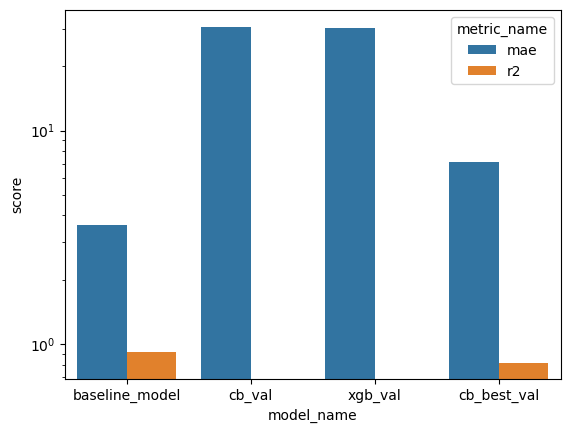

In [38]:
import matplotlib.pyplot as plt

sns.barplot(metrics, x='model_name', y='score', hue='metric_name',  )
plt.yscale('log')
